In [1]:
# Configurations
# Number of records to query from BigQuery
# None pulls all records   
limit=100
# Private key to access BiqQuery
#keyLocation = 'resource\local-receiver-341803-261a3b7beea6.json'
# Steve's Key
keyLocation = 'resource\local-receiver-341803-54a43db29fa7.json'

tableLocation = '`local-receiver-341803.trainEvents04_26.train-event-data`'

# Testing parameters
trainDataPercentage = 0.7
valDataPercentage = 0.2

In [4]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import json
import zipfile

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False



In [5]:
os.chdir(r"F://workspace//cloudcomputing//tensorflow")
os.getcwd()

'F:\\workspace\\cloudcomputing\\tensorflow'

In [ ]:
from google.cloud import bigquery

# Fetch Credentials - I created a key then literally dragged/dropped it to /content on google colab 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = keyLocation

# Build BigQuery Client
client = bigquery.Client()

In [18]:
# Get the dataset
# Query for Position Histories from BigQuery - change limit after we know it works
limitClause = '' if limit==None else ' Limit ' + str(limit)
QUERY = ('SELECT lastTrainReporting FROM ' + tableLocation + limitClause) 
query_job = client.query(QUERY)

# Wait for job to finish
rows = query_job.result()

print("Num rows fetched: " + str(rows.total_rows))

Num rows fetched: 100


In [19]:
# Define Utility Functions to build additional data rows

# Create a dataframe row holding a record of position on the train.
def createPositionHistoryFrame(positionHistory) -> dict:
    # The time that the train was at the specific milepost
    # Record the position time as seconds from epoch to use in regression model
    positionTime = positionHistory.get('positionTime')
    # How fast the train is traveling
    speedMPH = positionHistory.get('speedMPH')
    # Milepost location information
    milepostLocation = positionHistory.get('milepostLocation')
    # The unique identifier of the subdivision
    subdivisionId = milepostLocation.get('subdivisionId')
    # The unique identifier fo the milepost
    milepostNumber = milepostLocation.get('milepost').get('milepostNumber')

    # Construct new dataframe record
    return {'PositionTime': positionTime, 'SpeedMPH': speedMPH, 
    'SubdivisionId': subdivisionId, 'MilepostNumber':milepostNumber}

# Create a dataframe row for the identifier information of the trani
def createTrainIdFrame(trainId) -> dict:
    trainSymbol = trainId.get('trainSymbol')
    return {'TrainSymbol': trainSymbol}

# Create data frame for train detail
def createTrainDetailFrame(trainDetail) -> dict:
    maximumTrainSpeed = trainDetail.get('maximumTrainSpeed')
    loadedCarCount = trainDetail.get('loadedCarCount')
    emptyCarCount = trainDetail.get('emptyCarCount')
    trainLength = trainDetail.get('trainLength')
    trailingTonnage = trainDetail.get('trailingTonnage')

    # Construct new dataframe record
    return {'MaximumTrainSpeed': maximumTrainSpeed, 'LoadedCarCount': loadedCarCount, 
    'EmptyCarCount': emptyCarCount, 'TrainLength':trainLength, 'TrailingTonnage':trailingTonnage}

In [20]:
# Fetch each position time and milepost
aggregateDataFrame = pd.DataFrame()

# For each returned record
for row in rows:
    lastTrainReporting = row.get('lastTrainReporting')

    trainIdFrame = createTrainIdFrame(lastTrainReporting.get('trainId'))
    trainDetailFrame = createTrainDetailFrame(lastTrainReporting)

    # Scan each position history
    for positionHistory in lastTrainReporting.get('positionHistoryList'):
        # The time that the train was at the specific milepost
        # Record the position time as seconds from epoch to use in regression model
        positionHistoryFrame = createPositionHistoryFrame(positionHistory)

        # Add additional records to position history frame
        positionHistoryFrame.update(trainIdFrame)
        positionHistoryFrame.update(trainDetailFrame)

        # Append the row to the data frame.
        aggregateDataFrame = pd.concat([aggregateDataFrame, pd.DataFrame.from_records(positionHistoryFrame)], ignore_index = True)

#Return an item and drop from frame
date_time = pd.to_datetime(aggregateDataFrame.pop("PositionTime"), format='%Y-%m-%d %H:%M:%S')

print("date time: \n" + str(date_time))
print("cols: " + str(aggregateDataFrame.columns))

aggregateDataFrame.head()

ValueError: If using all scalar values, you must pass an index

In [6]:
# Handle Encoding of the data
# Note - to rerun this query - you need to run the above.
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'TrainSymbol'.
aggregateDataFrame['TrainSymbol'] = label_encoder.fit_transform(aggregateDataFrame['TrainSymbol'])
# Can decode values with label encoder inverse
inverse = label_encoder.inverse_transform(aggregateDataFrame['TrainSymbol'])

# Display Encoded Values
aggregateDataFrame.head()

,SpeedMPH,SubdivisionId,MilepostNumber,TrainSymbol,MaximumTrainSpeed,LoadedCarCount,EmptyCarCount,TrainLength,TrailingTonnage
0,-11,106,766.9261,4,50,44,51,5205,7586
1,-10,595,279.0362,4,50,44,51,5205,7586
2,-9,595,279.1244,4,50,44,51,5205,7586
3,-7,595,279.2209,4,50,44,51,5205,7586
4,-3,595,279.3100,4,50,44,51,5205,7586


SpeedMPH             38
SubdivisionId         4
MilepostNumber       76
TrainSymbol           5
MaximumTrainSpeed     2
LoadedCarCount        4
EmptyCarCount         5
TrainLength           7
TrailingTonnage       8
dtype: int64


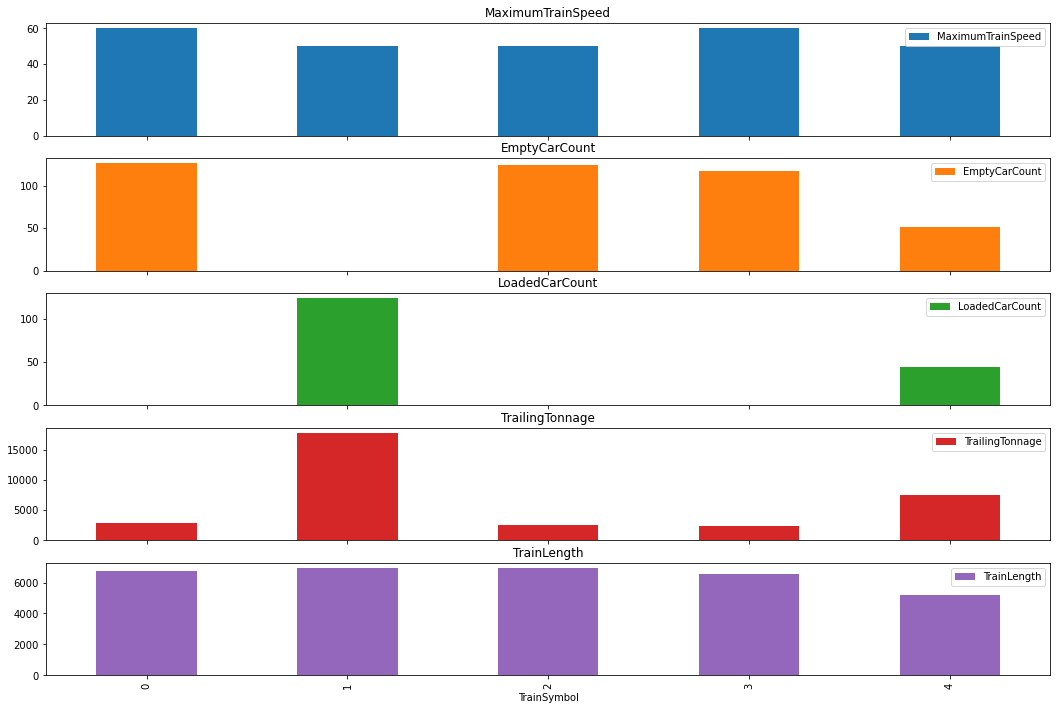

In [8]:
# Show of unique fields per column
print(aggregateDataFrame.nunique())

# Configuration Details of Train.
config_plot_cols = ['TrainSymbol', 'MaximumTrainSpeed', 'EmptyCarCount', 'LoadedCarCount', 'TrailingTonnage', 'TrainLength']

# Plot configuration details by train
config_plot_features = aggregateDataFrame[config_plot_cols]
_ = config_plot_features[config_plot_cols].groupby('TrainSymbol').first().plot(subplots=True, sharex=True, kind='bar', figsize=(18,12))

C:\Users\Steve\AppData\Local\Temp\ipykernel_35060\506131621.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_features.loc[:,'TrainSymbol'] = label_encoder.inverse_transform(plot_features.loc[:,'TrainSymbol'])


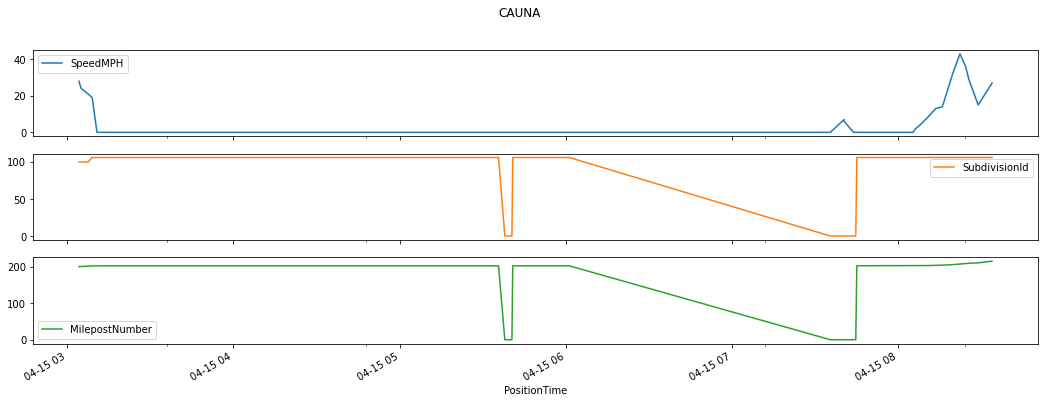

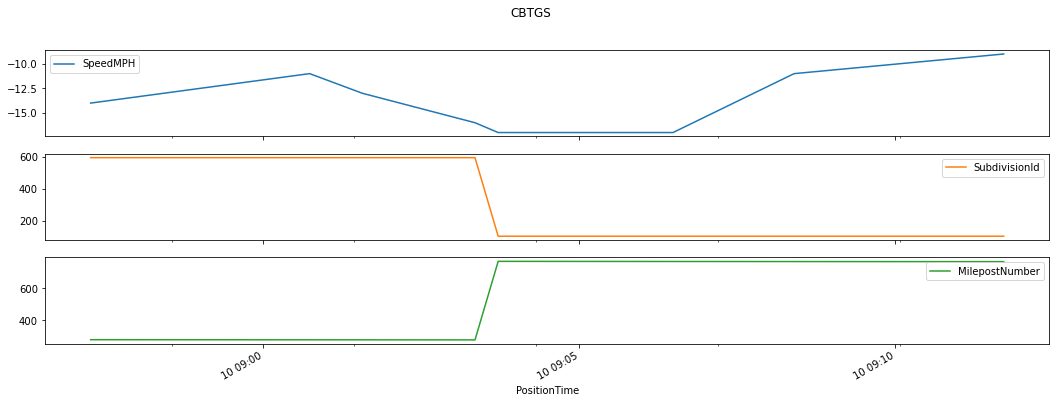

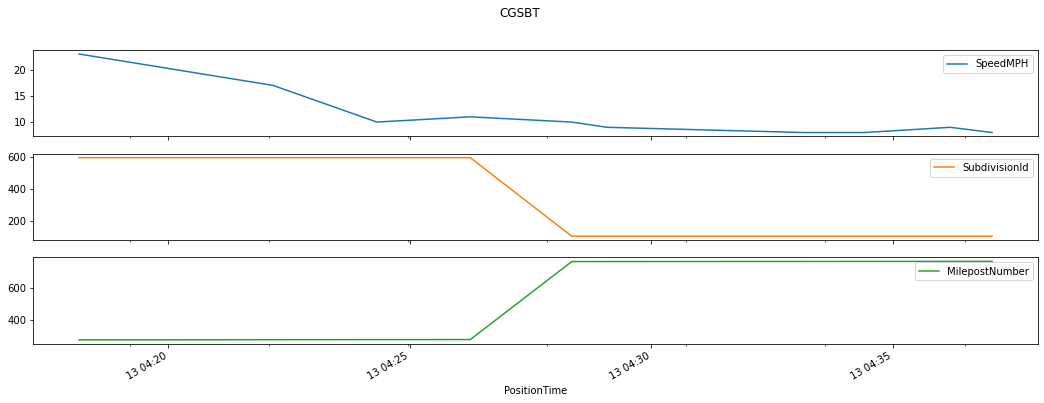

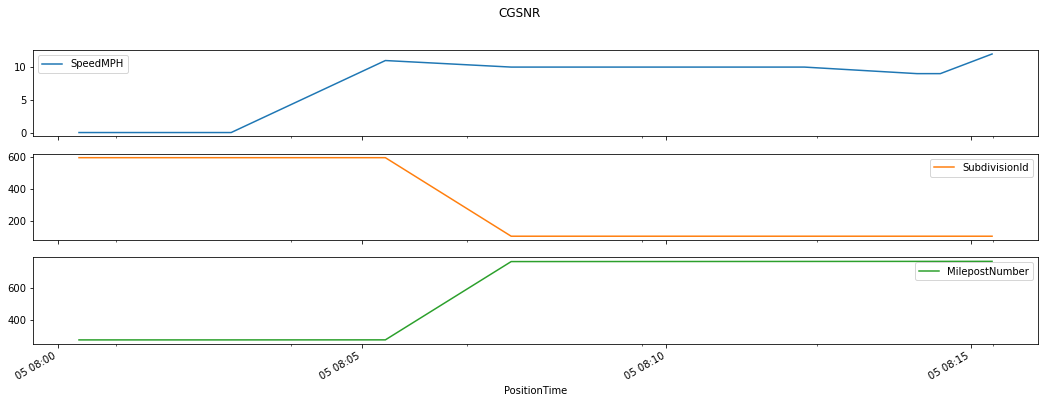

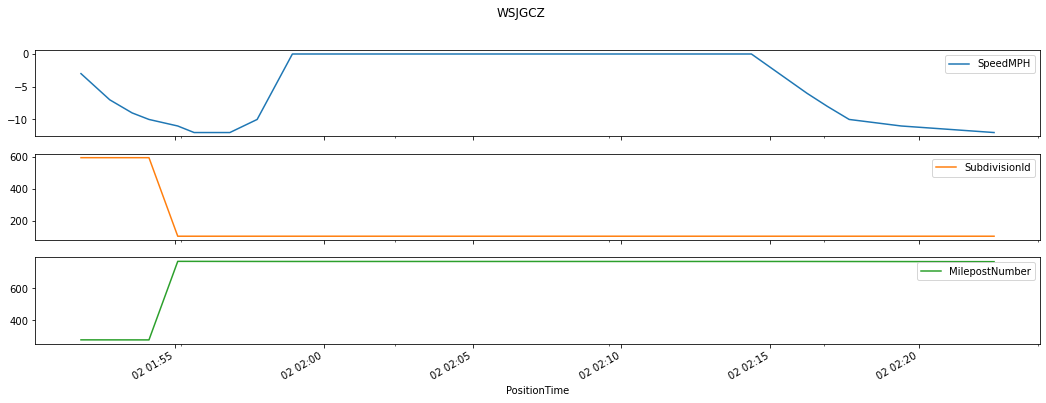

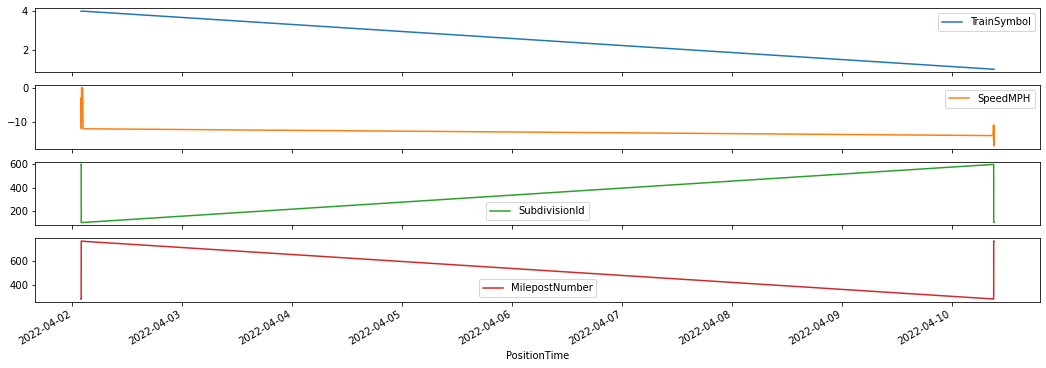

In [9]:
# Evolution of Features over time
plot_cols = ['TrainSymbol', 'SpeedMPH', 'SubdivisionId', 'MilepostNumber']

# Plot data over time
# Data by train symbol
plot_features = aggregateDataFrame[plot_cols]
plot_features.index = date_time

# Inverse TrainSymbol
plot_features.loc[:,'TrainSymbol'] = label_encoder.inverse_transform(plot_features.loc[:,'TrainSymbol'])

groupby_df = plot_features[plot_cols].groupby('TrainSymbol')

# Iterate through subplots to add train symbol title
for key in groupby_df.groups.keys():
    groupby_df.get_group(key).plot(subplots=True, title=key, sharey=False, figsize=(18,6))

# Aggregate Data
plot_features = aggregateDataFrame[plot_cols][:limit]
plot_features.index = date_time[:limit]
_ = plot_features.plot(subplots=True, sharex=True, figsize=(18,6))

In [10]:
# Inspect and clean up - look at statistics of dataset
aggregateDataFrame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SpeedMPH,500.0,1.860000,9.924787,-17.0,0.0000,0.0000,2.000000,43.0000
SubdivisionId,500.0,141.608000,135.124163,0.0,106.0000,106.0000,106.000000,595.0000
MilepostNumber,500.0,348.837991,251.064406,0.0,202.5348,202.8155,764.868875,766.9261
TrainSymbol,500.0,0.980000,1.524549,0.0,0.0000,0.0000,2.000000,4.0000
MaximumTrainSpeed,500.0,57.200000,4.494486,50.0,50.0000,60.0000,60.000000,60.0000
LoadedCarCount,500.0,17.820000,31.252857,0.0,0.0000,0.0000,21.000000,124.0000
EmptyCarCount,500.0,106.510000,37.741738,0.0,117.0000,126.0000,126.000000,126.0000
TrainLength,500.0,6831.270000,915.651710,5205.0,6761.0000,6761.0000,6918.000000,8406.0000
TrailingTonnage,500.0,4948.160000,3709.442824,2457.0,2893.0000,2893.0000,5707.000000,17732.0000


Text(0.5, 1.0, 'Time of day signal thing')

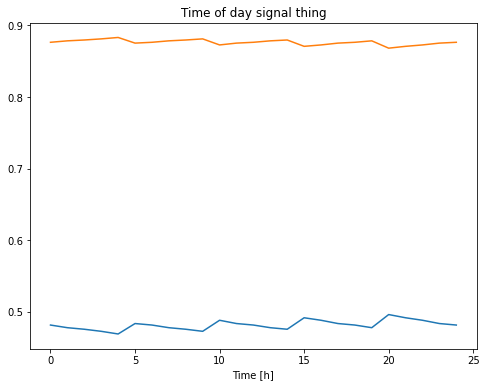

In [831]:
# TODO - Is this needed?

# Date time updates
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

dateTimeDataframe = pd.DataFrame()

dateTimeDataframe['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dateTimeDataframe['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dateTimeDataframe['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dateTimeDataframe['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(dateTimeDataframe['Day sin'])[:25])
plt.plot(np.array(dateTimeDataframe['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal thing')

In [832]:
# Finally get to some training things - split the data

column_indices = {name: i for i, name in enumerate(aggregateDataFrame.columns)}

print('Column Indices', column_indices)

n = len(aggregateDataFrame)

# Splitting the data set
test_percentage = trainDataPercentage + valDataPercentage
train_df = aggregateDataFrame[0:int(n*trainDataPercentage)]
val_df = aggregateDataFrame[int(n*trainDataPercentage):int(n*test_percentage)]
test_df = aggregateDataFrame[int(n*test_percentage):]

print('Train Percent:', str(trainDataPercentage))
print('Val Percent:', str(valDataPercentage))
print('Test Percent:', str(round(1 - test_percentage, 1)))

num_features = aggregateDataFrame.shape[1]

Column Indices {'EmptyCarCount': 0, 'LoadedCarCount': 1, 'MaximumTrainSpeed': 2, 'MilepostNumber': 3, 'SpeedMPH': 4, 'SubdivisionId': 5, 'TrailingTonnage': 6, 'TrainLength': 7, 'TrainSymbol': 8}
Train Percent: 0.7
Val Percent: 0.2
Test Percent: 0.1


In [833]:
# Now we normalize the data - required before training a neural network. 

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

print('Train df:', str(train_df))
print('Val df:', str(val_df))
print('Test df:', str(test_df))

Train df:      EmptyCarCount  LoadedCarCount  MaximumTrainSpeed  MilepostNumber  \
0        -1.110448        0.655459          -1.222994        1.297683   
1        -1.110448        0.655459          -1.222994       -0.529204   
2        -1.110448        0.655459          -1.222994       -0.528874   
3        -1.110448        0.655459          -1.222994       -0.528512   
4        -1.110448        0.655459          -1.222994       -0.528179   
..             ...             ...                ...             ...   
345       0.655638       -0.549084           0.815329       -0.815662   
346       0.655638       -0.549084           0.815329       -0.815662   
347       0.655638       -0.549084           0.815329       -0.815661   
348       0.655638       -0.549084           0.815329       -0.815660   
349       0.655638       -0.549084           0.815329       -0.815660   

     SpeedMPH  SubdivisionId  TrailingTonnage  TrainLength  TrainSymbol  
0   -1.303242      -0.357448         0.

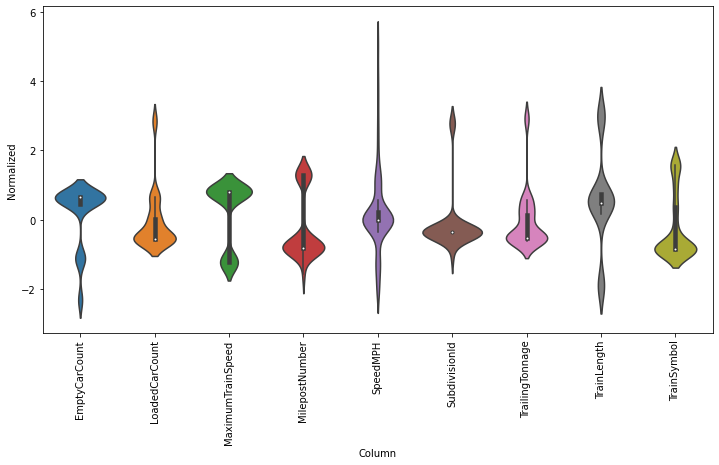

In [834]:
# View distribution of the features - look for obvious errors here
df_std = (aggregateDataFrame - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(aggregateDataFrame.keys(), rotation=90)

In [835]:
# Data Windowing - done for reuse and for making prediction x hours into the future given y hours of history
# Main features: width of input and label windows, time offset between them, which features are used as inputs, labels or both

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [836]:
# Now add code to create 2 windows  (note: try different columns here)

w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['MilepostNumber'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['MilepostNumber']

In [837]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['MilepostNumber'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['MilepostNumber']

In [838]:
# Pull out the layer's weights and visualize the weight assigned to each input
def weight_graph(model):
    plt.bar(x = range(len(train_df.columns)),
            height=model.layers[0].kernel[:,0].numpy())
    axis = plt.gca()
    axis.set_xticks(range(len(train_df.columns)))
    _ = axis.set_xticklabels(train_df.columns, rotation=90)

In [839]:
# Utility function 
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [840]:
# Make use of the window splitting feature
# Note you need enough data for this to work

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
Labels shape: (3, 1, 1)


In [841]:
# Now, plot!
w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='MilepostNumber', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

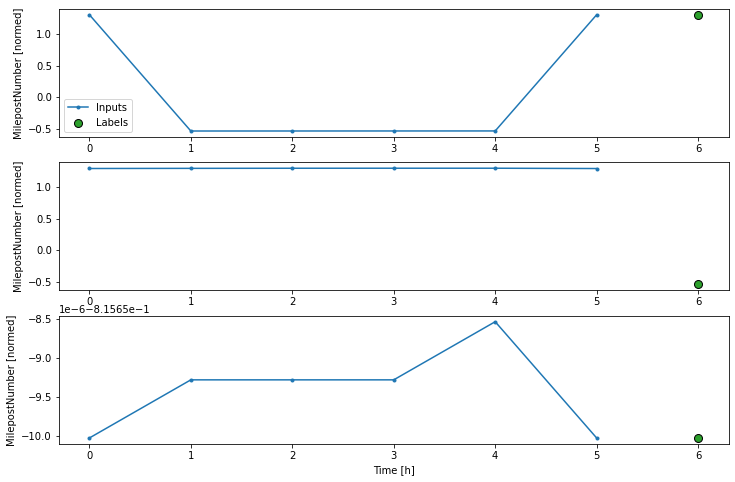

In [842]:
# Here is where we show the plot
w2.plot()

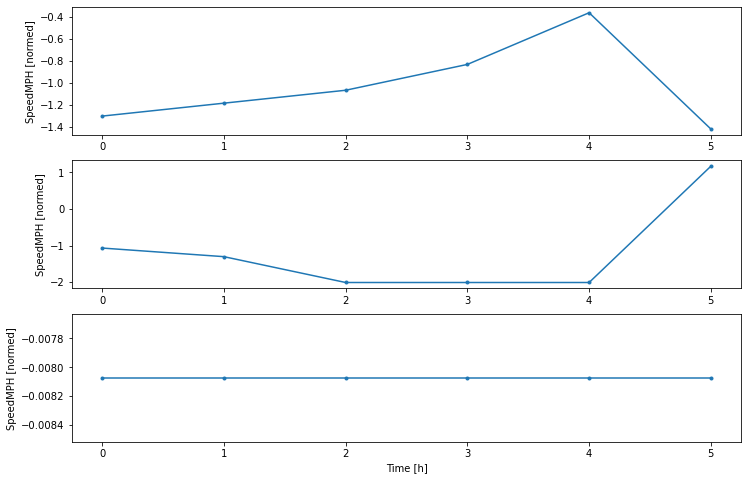

In [843]:
w2.plot(plot_col='SpeedMPH')

In [844]:
# Make some datasets
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [845]:
# Add properties to the datasets
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [846]:
# The window generator gives us access to the tensor flow dataset objects for easy iteration 
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [847]:
# let's look at concrete batches
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [848]:
# Need to configure a window generator to produce single-step pairs
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['MilepostNumber'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['MilepostNumber']

In [849]:
# Once again, look at the batches of date:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

In [850]:
# Build a performance baseline - to use as point for comparison
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [851]:
# Instantiate and evaluate the model:
baseline = Baseline(label_index=column_indices['MilepostNumber'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

4/4 [==============================] - 0s 1ms/step - loss: 0.0823 - mean_absolute_error: 0.1084


In [852]:
# Still, we don't know how well the model is doing. Generate more info
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['MilepostNumber'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['MilepostNumber']

In [853]:
# Now print the shapes
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


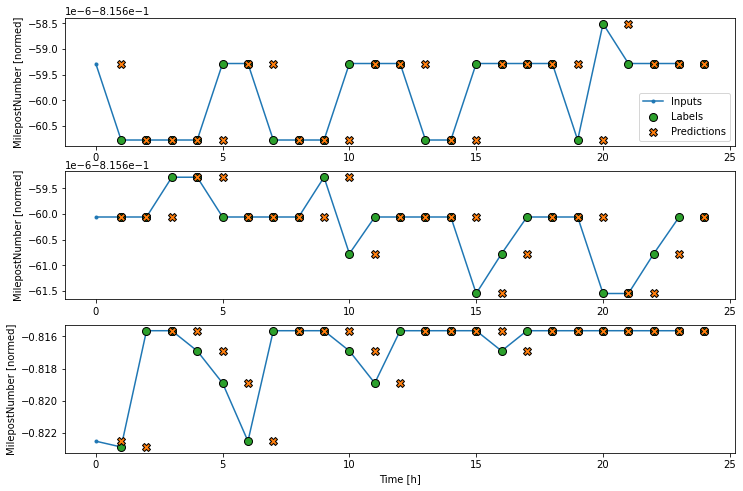

In [854]:
wide_window.plot(baseline, plot_col='MilepostNumber')

In [855]:
# Now, let's start looking at a Linear Model! Note that a Dense layer with no activation set is a linear model
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [856]:
# Package training procedure into a function:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [857]:
# Train the model and evaluate its performance
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
11/11 [==============================] - 0s 12ms/step - loss: 3.6551 - mean_absolute_error: 1.7899 - val_loss: 4.7684 - val_mean_absolute_error: 2.1152
Epoch 2/20
11/11 [==============================] - 0s 6ms/step - loss: 3.4780 - mean_absolute_error: 1.7420 - val_loss: 4.5111 - val_mean_absolute_error: 2.0553
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: 3.3131 - mean_absolute_error: 1.6962 - val_loss: 4.2644 - val_mean_absolute_error: 1.9961
Epoch 4/20
11/11 [==============================] - 0s 6ms/step - loss: 3.1597 - mean_absolute_error: 1.6524 - val_loss: 4.0327 - val_mean_absolute_error: 1.9389
Epoch 5/20
11/11 [==============================] - 0s 6ms/step - loss: 3.0144 - mean_absolute_error: 1.6092 - val_loss: 3.8099 - val_mean_absolute_error: 1.8823
Epoch 6/20
11/11 [==============================] - 0s 6ms/step - loss: 2.8779 - mean_absolute_error: 1.5673 - val_loss: 3.6088 - val_mean_absolute_error: 1.8298
Epoch 7/20
11/11 [=========

In [858]:
# Again, print the shapes
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


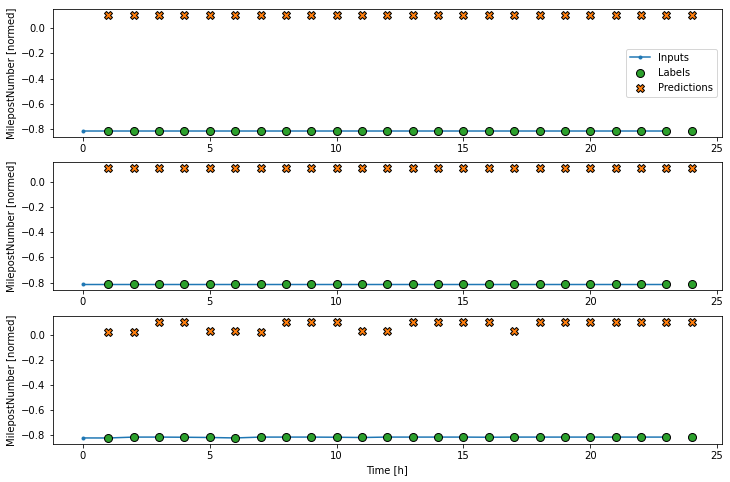

In [859]:
wide_window.plot(linear)

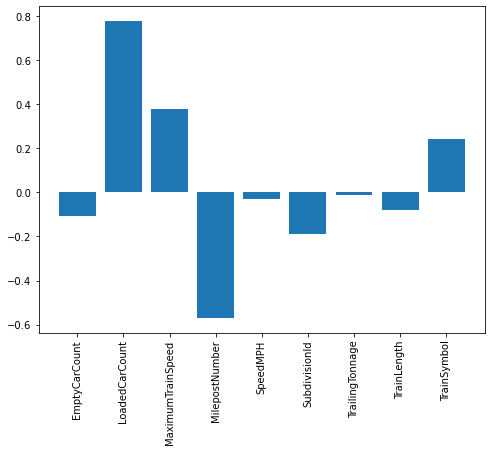

In [860]:
weight_graph(linear)

### Dense Model

In [861]:
# Now it's time to look at a Dense model. Note the stacking of layers between input and output
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
11/11 [==============================] - 1s 16ms/step - loss: 0.6877 - mean_absolute_error: 0.7783 - val_loss: 0.3164 - val_mean_absolute_error: 0.4991
Epoch 2/20
11/11 [==============================] - 0s 6ms/step - loss: 0.3316 - mean_absolute_error: 0.4253 - val_loss: 0.0797 - val_mean_absolute_error: 0.1878
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: 0.2563 - mean_absolute_error: 0.3012 - val_loss: 0.0818 - val_mean_absolute_error: 0.2261
Epoch 4/20
11/11 [==============================] - 0s 6ms/step - loss: 0.2309 - mean_absolute_error: 0.2891 - val_loss: 0.0635 - val_mean_absolute_error: 0.1742
Epoch 5/20
11/11 [==============================] - 0s 6ms/step - loss: 0.2423 - mean_absolute_error: 0.2535 - val_loss: 0.0637 - val_mean_absolute_error: 0.1464
Epoch 6/20
4/4 [==============================] - 0s 988us/step - loss: 0.0658 - mean_absolute_error: 0.1648


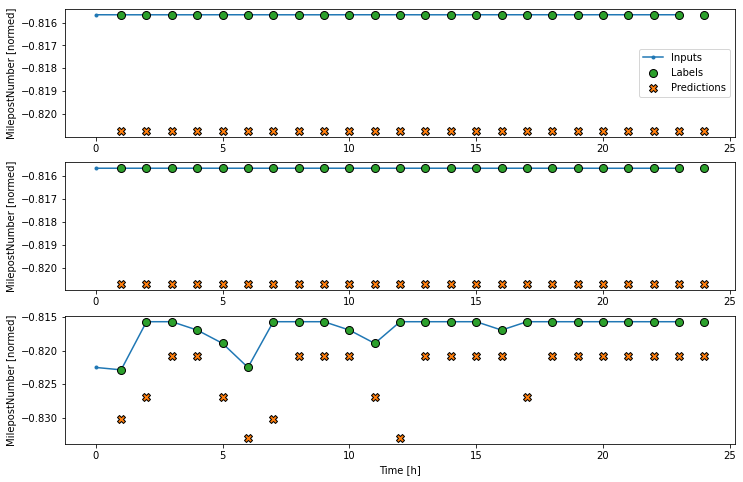

In [862]:
wide_window.plot(dense)

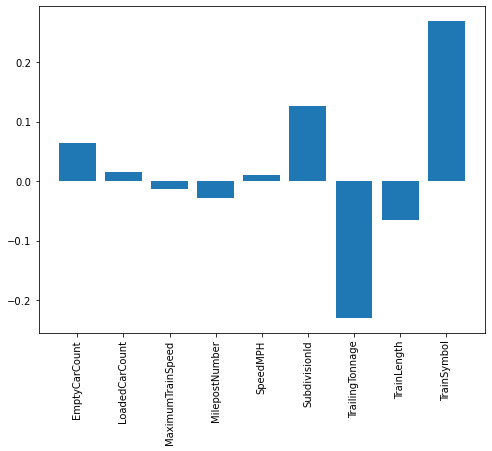

In [863]:
weight_graph(dense)

### Multi Dense Model

In [864]:
# Create another window generator to produce batches of inputs and labels
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['MilepostNumber'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['MilepostNumber']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

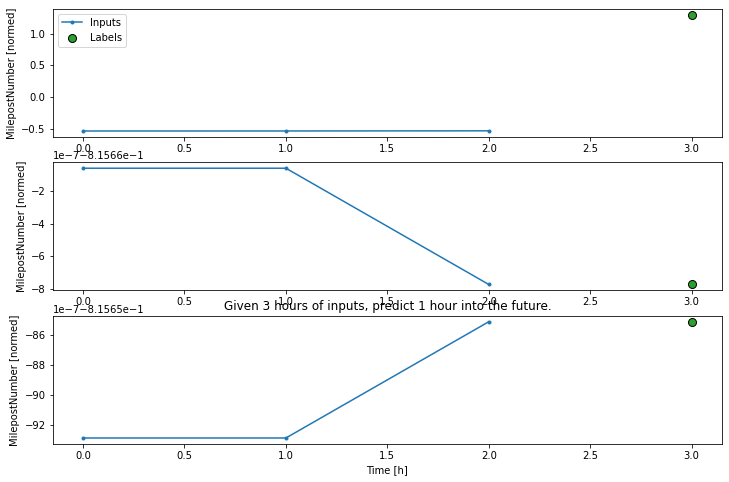

In [865]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [866]:
# Try adding a flatten layer as the first layer. Why? To possibly train on a multi-input-step 
multi_step_dense = tf.keras.Sequential([window
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

SyntaxError: invalid syntax (<ipython-input-866-5d18df9d0aef>, line 4)

In [ ]:
# Shape time
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [ ]:
# Compile and fit the model. Then evaluate
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

3/3 [==============================] - 0s 999us/step - loss: 0.1612 - mean_absolute_error: 0.2877


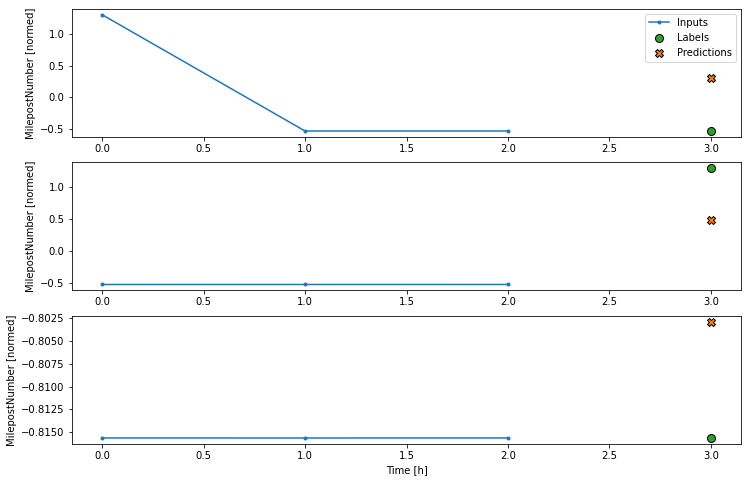

In [ ]:
conv_window.plot(multi_step_dense)

### Convolution Neural Network

In [ ]:
# Convolution Nural Network time! These also take multiple time steps as input to each prediction
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
# Run on an example batch - does the model produce the expected shape? 
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [ ]:
# Train and evaluate the model on the conv_window and it should give similar performance to the multi step dense model:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

3/3 [==============================] - 0s 1ms/step - loss: 0.0732 - mean_absolute_error: 0.1393


In [ ]:
# Run it on wider input, produce wider output?
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 9)
Labels shape: (32, 24, 9)
Output shape: (32, 22, 1)


In [ ]:
# We need the labels and prediction to have the same length. So, let's build a WindowGenerator, shall we? 

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['MilepostNumber'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['MilepostNumber']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


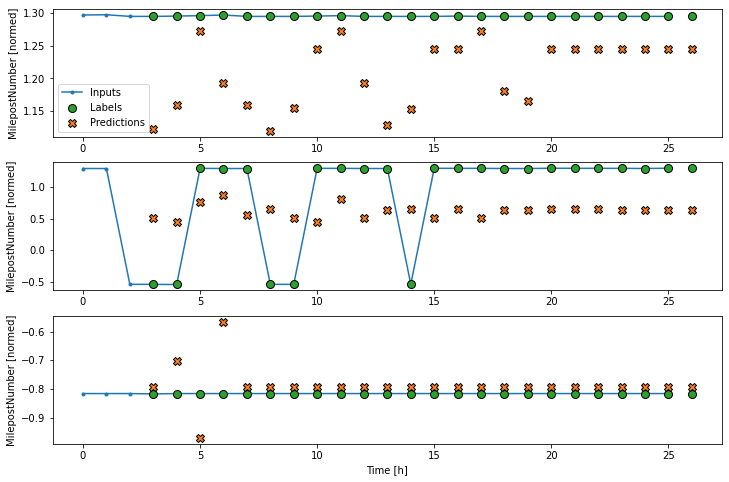

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent Neural Network

A Recurrent Neural Network is a type of neural network well-suited to time series data. RNNs process a time series step by step.
We'll use Long short-term memory (LSTM) here

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

3/3 [==============================] - 0s 3ms/step - loss: 0.1266 - mean_absolute_error: 0.2338


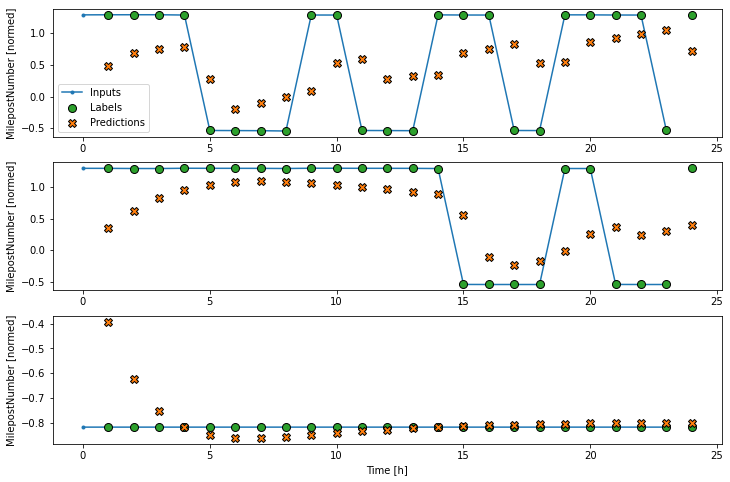

In [ ]:
wide_window.plot(lstm_model)


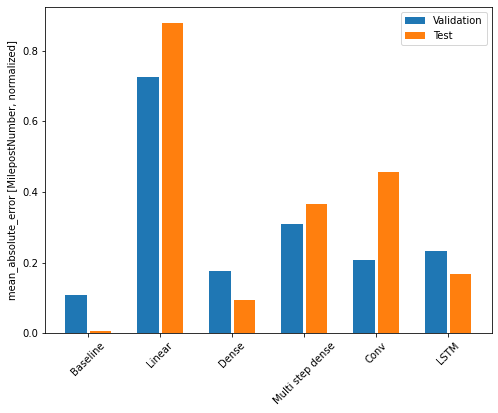

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [MilepostNumber, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
# Print the values for text comparison
for name, value in performance.items():
  print(f'{name:18s}: {value[1]:0.4f}')

Baseline          : 0.0053
Linear            : 0.8796
Dense             : 0.0953
Multi step dense  : 0.3673
Conv              : 0.4573
LSTM              : 0.1680


### Multi-output Models
Convert all prior single step models to multi-output models by changing the number of units in the output layer and adjusting the training windows to include all features

In [ ]:
# What do multi-output models look like? Can we predict multiple features? Yes, just change the number of units in the output layer,
# and adjust the training windows to inlude all features in the labels 

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 9)
Labels shape (batch, time, features): (32, 24, 9)


In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

3/3 [==============================] - 0s 999us/step - loss: 0.0320 - mean_absolute_error: 0.0382


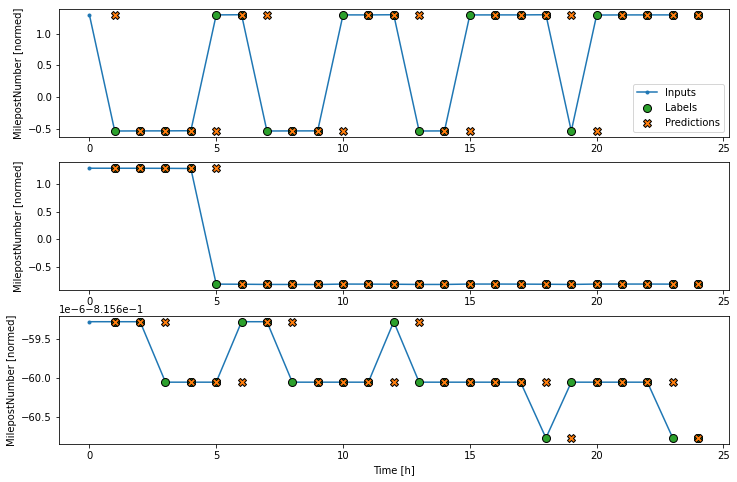

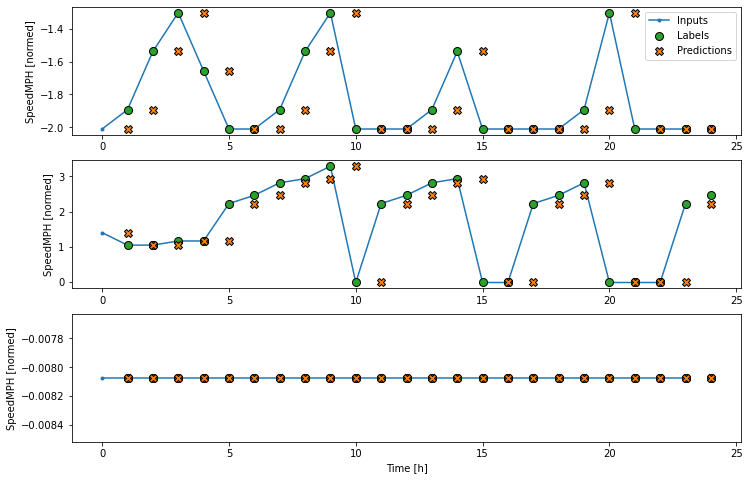

In [ ]:
wide_window.plot(baseline)
wide_window.plot(baseline, plot_col='SpeedMPH')

#### Dense Model

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

4/4 [==============================] - 0s 999us/step - loss: 0.2074 - mean_absolute_error: 0.2047


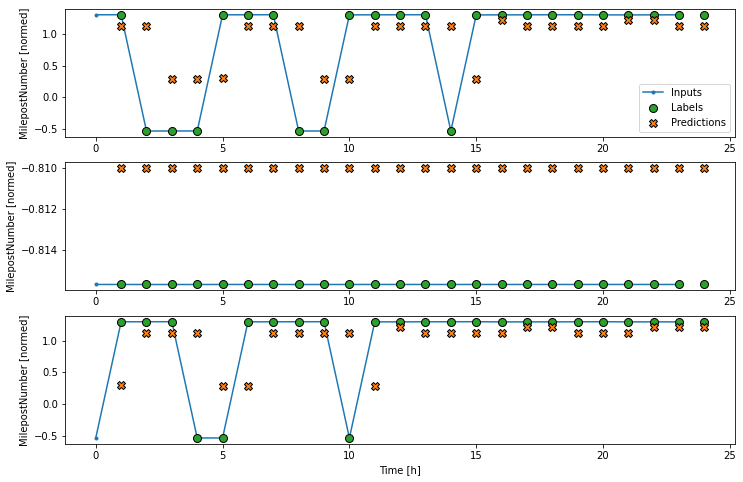

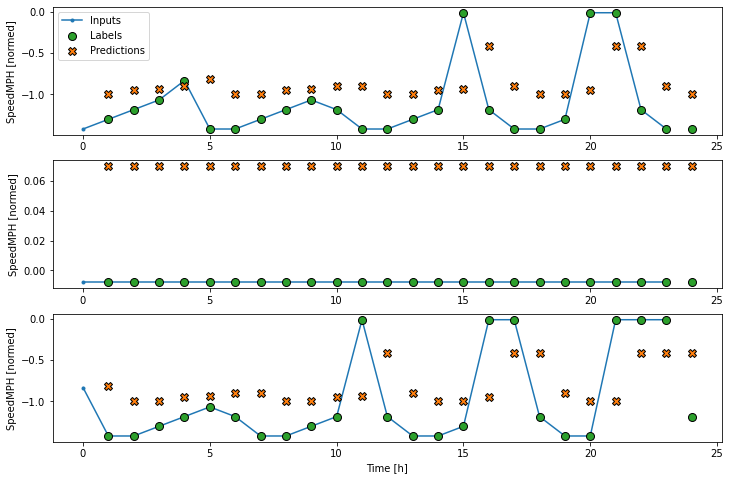

In [ ]:
wide_window.plot(dense)
wide_window.plot(dense, plot_col='SpeedMPH')

#### Recurrent Neural Network

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)


3/3 [==============================] - 0s 3ms/step - loss: 0.3091 - mean_absolute_error: 0.2758


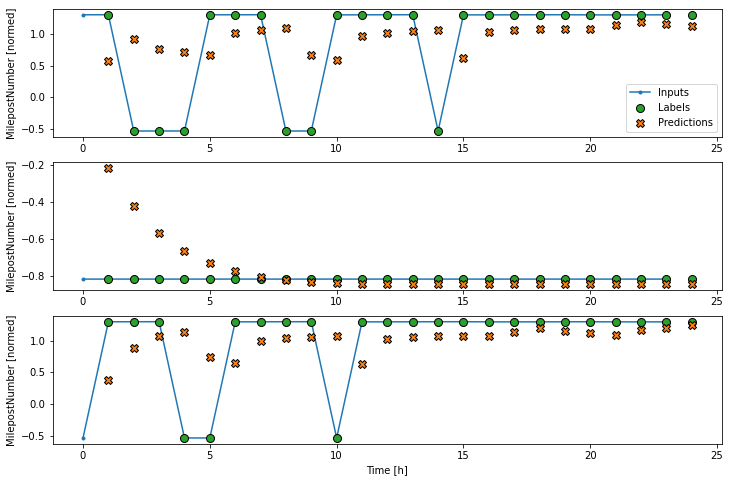

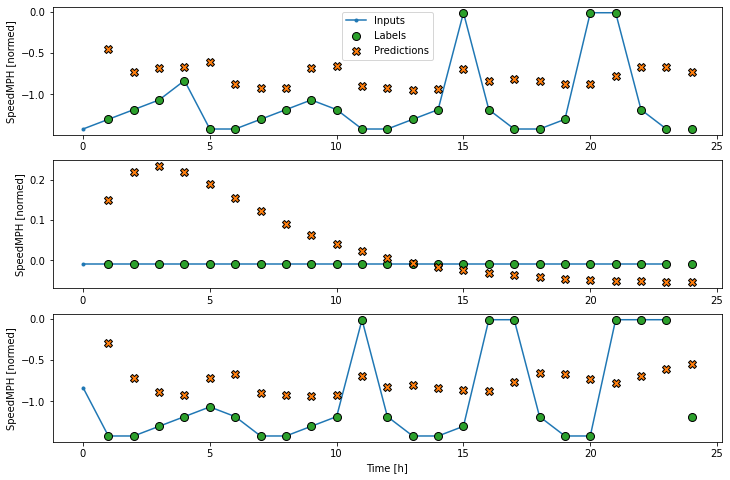

In [ ]:
wide_window.plot(lstm_model)
wide_window.plot(lstm_model, plot_col='SpeedMPH')

#### Residual Connections
Instead of trying to predict the next value - attempt to predict how the value will change. 

In [ ]:
# Look at a Residual Network - each layer adds to the model's accumulating result
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

3/3 [==============================] - 0s 3ms/step - loss: 0.0326 - mean_absolute_error: 0.0517


### Performance - Multi-output models

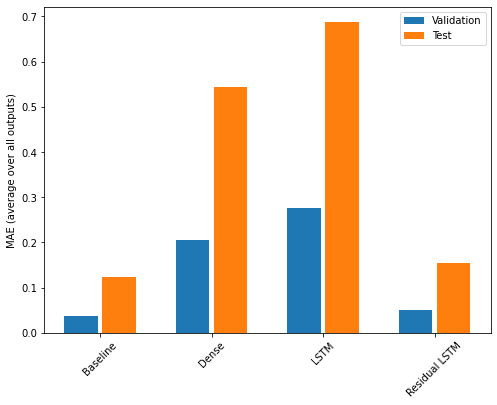

In [ ]:
# Once again, let's look at model performance comparison, now with more layers! (new and improved ;))
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1243
Dense          : 0.5443
LSTM           : 0.6871
Residual LSTM  : 0.1536


## Multi-step Models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

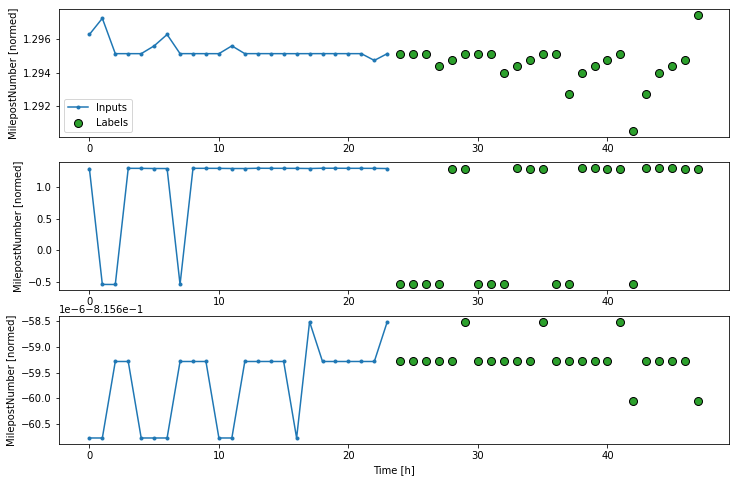

In [ ]:
# Begin looking at multi step models. The idea is to do multiple time step predictions. The model needs to learn to predict 
# a range of future values, like a sequence.  Think of predicting 24 hours into the future, given 24 hours of the past

OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

2/2 [==============================] - 0s 2ms/step - loss: 0.2065 - mean_absolute_error: 0.1682


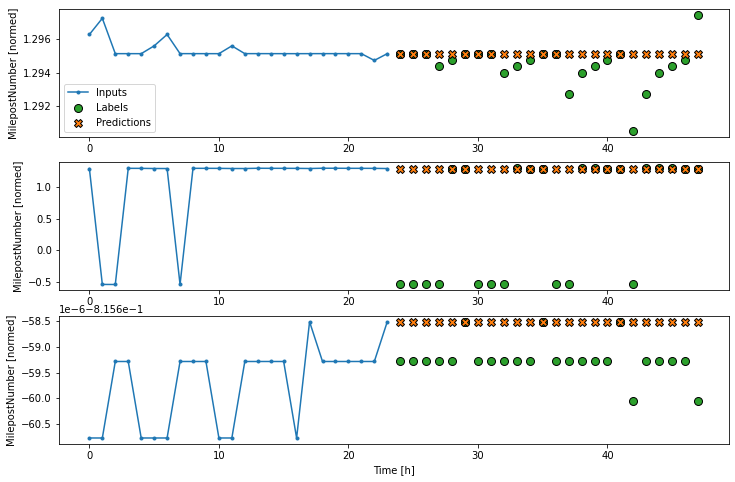

In [ ]:
# Create a function to repeat the last input time step for some number of output time steps
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

2/2 [==============================] - 0s 2ms/step - loss: 0.3217 - mean_absolute_error: 0.2287


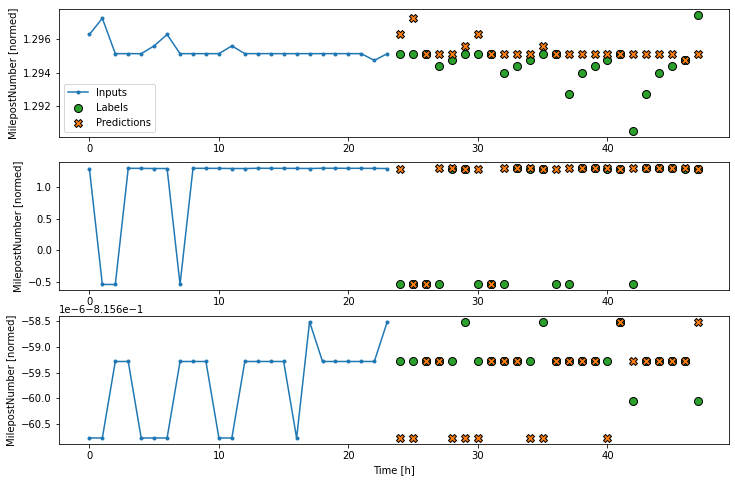

In [ ]:
# Now create a function to repeat the baseline
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single Shot Models
#### Linear Model

2/2 [==============================] - 0s 2ms/step - loss: 0.4086 - mean_absolute_error: 0.3542


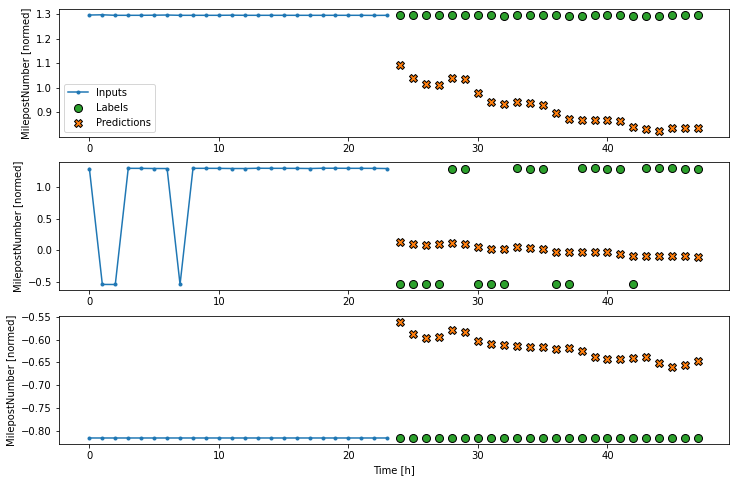

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense Model

2/2 [==============================] - 0s 2ms/step - loss: 0.3715 - mean_absolute_error: 0.3140


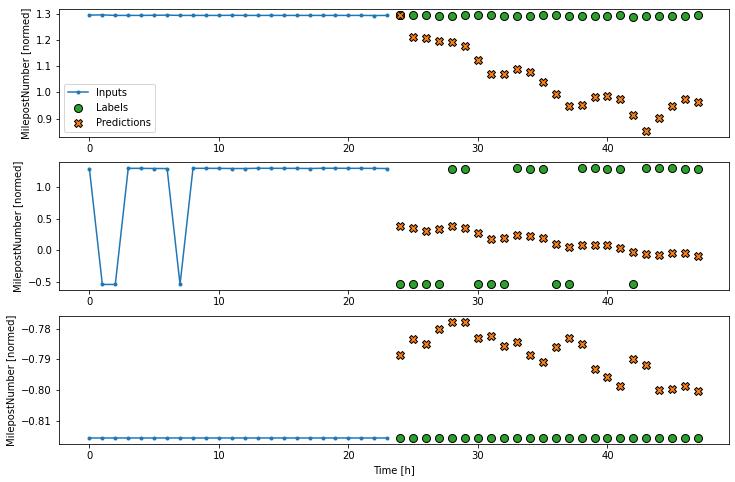

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### Convolutional Model

2/2 [==============================] - 0s 2ms/step - loss: 0.3883 - mean_absolute_error: 0.3013


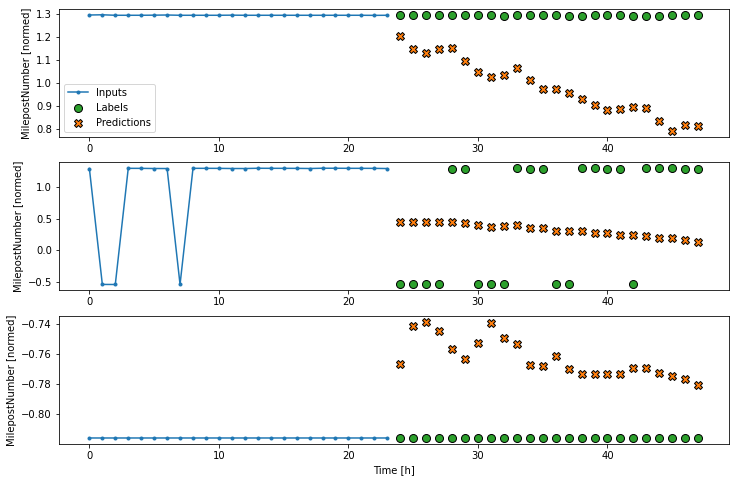

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### Reccurrent Model

2/2 [==============================] - 0s 3ms/step - loss: 0.4505 - mean_absolute_error: 0.3400


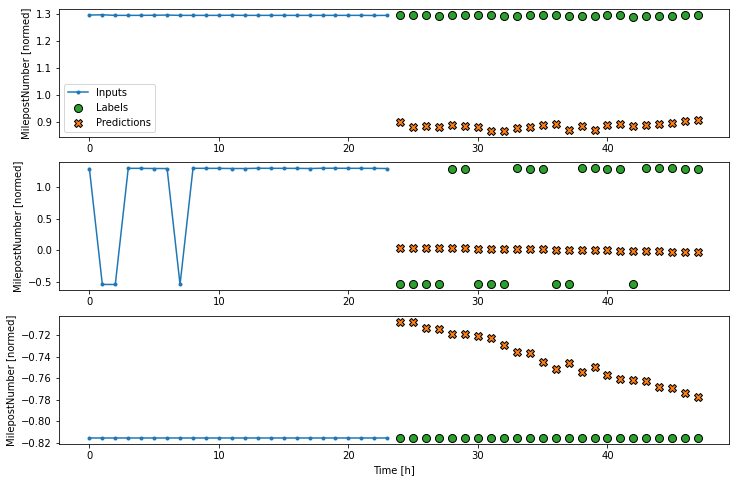

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Autoregressive Models
The above models all predict the entire output sequence in a single step.

#### Recurrent Neural Network

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 9])

In [ ]:
# Do the actual prediction - having to collect output predictions and retain them while iterating through each step

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
# Run on example inputs and see the shape:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 9)


2/2 [==============================] - 0s 5ms/step - loss: 0.4212 - mean_absolute_error: 0.3050


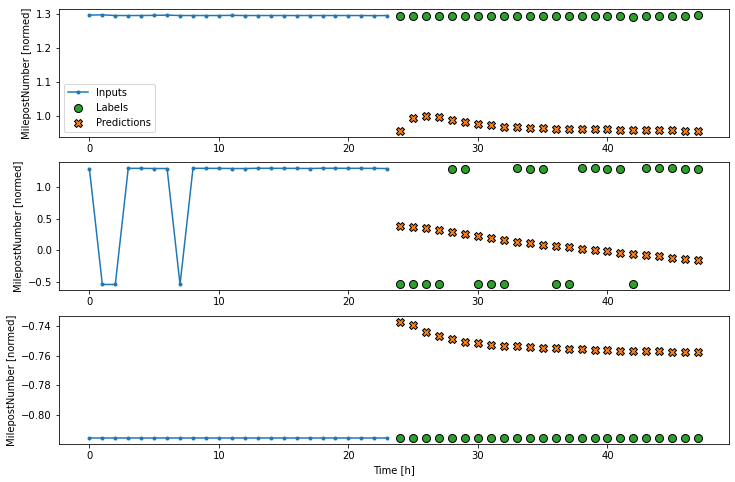

In [ ]:
# Now train the model
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

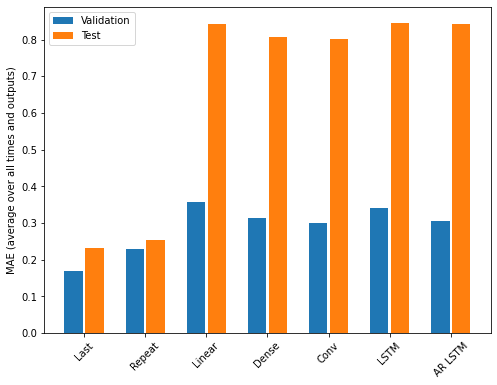

In [ ]:
# Evaluate Performance
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
# Text output for easy comparison 
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.2324
Repeat  : 0.2537
Linear  : 0.8437
Dense   : 0.8083
Conv    : 0.8005
LSTM    : 0.8465
AR LSTM : 0.8436
